In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import sys
import time
from multiprocessing import Process, Pool
import warnings
warnings.simplefilter('ignore')

# Add module path to system path
module_paths = ['..','../../', 
                '../extern',
                '../extern/PsrPopPy',
                '../extern/pymag_tree'
#                 '/usr/local/lib/python3.8/site-packages'
               ]
for module_path in module_paths:
    if os.path.abspath(os.path.join(module_path)) not in sys.path:
        sys.path.insert(0, module_path)
    
    
# For convenience
import numpy as np
import pandas as pd

from epn_mining.main import load_states, save, load
from epn_mining.preparation.pulsar import Population
from epn_mining.topology import topology
from epn_mining.analysis.stats import (
    centroid as compute_centroid, 
#     evaluate_DPGMM,
    convert_x_to_phase
)
from epn_mining.analysis import stats
from epn_mining.analysis.distance import (check_bound, check_min_max, check_neg, Distance)

from epn_mining.preparation.signal import (
    shift_max_to_center, 
    shift_centroid_to_center,
    best_alignment
)

from epn_mining.analysis import plotting

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits import axes_grid1
from matplotlib import rc
from matplotlib import style, collections as mc, colors, cm
import matplotlib.patheffects as PathEffects

style.use('default')

import json
from sklearn import mixture
from scipy.stats import norm, linregress, gaussian_kde
from joblib import parallel_backend
from tqdm import tqdm

# from dtaidistance import dtw

from dtw import dtw

# import astropy.coordinates as coord
# import astropy.units as u
# from astropy.coordinates import SkyCoord
# from astropy.stats import histogram, knuth_bin_width

# import lmfit

import copy

# Set session variables
verbose = True
state_store=True

pink = (230/255, 29/255, 95/255, 1)
pink_translucid = (230/255, 29/255, 95/255, .2)
blue = (47/255, 161/255, 214/255, 0.2)
blue_full = (47/255, 161/255, 214/255, 1)

cmap = cm.get_cmap('cubehelix').reversed()
# cmap = cm.get_cmap('tab20')

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [13]:
# goodies_pop = load('goodies_pop', state_prefix='multifreq_2_3_4_5')
# goodies_pop = load('goodies_pop', state_prefix='multifreq_2_3_4_5_resized')
# goodies_pop = load('goodies_pop', state_prefix='ska_meeting_2_3_4_5')

# state_prefix = 'paper_512_2_3_4_5'
# state_prefix = 'paper_512_2_4'
# state_prefix = 'paper_512_4'
state_prefix = 'frb_one_offs'

epn_metadata = load('epn_metadata', state_prefix=state_prefix)
goodies_pop = load('population', state_prefix=state_prefix)

# goodies_pop = load('goodies_pop', state_prefix=state_prefix)

goodies_pop = copy.deepcopy(goodies_pop)
goodies_pop

In [2]:
# state_prefix = 'multifreq_2_3_4_5_resized'
# state_prefix = 'ska_meeting_2_3_4_5'
# state_prefix = 'paper_512_2_3_4_5'
# state_prefix = 'paper_512_2_4'
metric = 'DTW'
stokes_to_include = [ 'model',
                     # 'mean_linear_polarization_degree',
                     # 'mean_circular_polarization_degree'
#                    'I',  'stokes_L', 
#                      'distance'
                    ]
freq_ids_to_include = [2]
# freq_ids_to_include = [2,4]
# freq_ids_to_include = [4]
_4freqs_ = True if len(freq_ids_to_include) > 1 else False
print (_4freqs_)

min_snr = 20

from dtw import rabinerJuangStepPattern

penalty = None
step_pattern = 'asymmetric' # rabinerJuangStepPattern(6, "d") # 'symmetric2'#'symmetricP05' #['', 'symmetric2']
window_type  = 'sakoechiba' #['sakoechiba', None]
window_args  = {'window_size': 256} #{'window_size': 512} #[{'window_size':204}, {}]
open_begin   = False #[False, True, True]
open_end     = False #[False, True, True]

# state_name = None
state_name = '%sbin%s_graph_%s%s_%s' % (len(freq_ids_to_include) if _4freqs_ else '',
                                             '' if _4freqs_ else 's' + str(freq_ids_to_include[0]),
                                             step_pattern, 
                                             '_%s' % window_type if window_type is not None else '',                 
                                             stokes_to_include[0]
                                            )

cropped = False
verbose = True

print ('state_name', state_name)

False
state_name bins2_graph_asymmetric_sakoechiba_model


In [3]:
# # distances, population_graph_indices, graph_population_indices = load(state_name, state_prefix=state_prefix + '_L_V')
# distances = load('distances', state_prefix=state_prefix)
# population_graph_indices = load('population_graph_indices', state_prefix=state_prefix)
# graph_population_indices = load('graph_population_indices', state_prefix=state_prefix)

distances, population_graph_indices, state_prefix, \
graph_population_indices, sequence_population, sequence_indices, mst = load('graph', state_prefix ='FRB_one_offs')

In [4]:
# mst = topology.spanning_tree(distances, type='minimum', verbose=verbose)
# sequence_population, sequence_indices, mst = topology.longest_path(mst,
#                                                                    goodies_pop.as_array(),
#                                                                    graph_population_indices,
#                                                                    verbose=verbose)
# elongation, normalized_elongation  =  mst.elongation()

# elongation_dict = {}
# elongation_dict[state_prefix] = {'elongation' : elongation,
#                                  'normalized_elongation' : normalized_elongation,
#                                  'length': mst.length(),
#                                  'half_width': mst.half_width(),
#                                  'longest_path' : len(sequence_population),
#                                  'N' : mst.V}

# Plotting variables
contracted = False
plot_polarization = False
plot_pa = False
plot_stokes_I = False
colour_by = 'branch'
# colour_by = 'rankin_class'
print_bname = False
annotate = True

# Compute DTW distances for cmap and norm

def get_dtws(phases, models):
    dtws = []
    for i in range(len(phases)-1):
        dtw1 = dtw(models[i], 
                   models[i+1], 
                   keep_internals=True,
                   step_pattern=step_pattern,
                   window_type=window_type,
                   window_args=window_args,
                   open_begin=open_begin,
                   open_end=open_end)
        dtw2 = dtw(models[i+1], 
                  models[i],
                  keep_internals=True,
                  step_pattern=step_pattern,
                  window_type=window_type,
                  window_args=window_args,
                  open_begin=open_begin,
                  open_end=open_end)
        dtws.append(dtw1 if dtw1.distance > dtw2.distance else dtw2)
    return np.array(dtws)

freqs_labels = {0: u'0-200 MHz', # in MHz
                1: u'200-400 MHz',
                2: u'400-700 MHz',
                3: u'700-1000 MHz',
                4: u'1000-1500 MHz',
                5: u'1500-2000 MHz',
                6: u'2000- MHz'}
freqs_filename = {0: u'0-200MHz', # in MHz
                  1: u'200-400MHz',
                  2: u'400-700MHz',
                  3: u'700-1000MHz',
                  4: u'1000-1500MHz',
                  5: u'1500-2000MHz',
                  6: u'2000+MHz'}

_distances = []
pulsars = goodies_pop.as_array()[sequence_indices] #[::-1]

# Evaluate global distances
for k, f in enumerate(freq_ids_to_include):
    profiles = [pulsar.observations[f].stokes_I for pulsar in pulsars]
    models = [pulsar.observations[f].model for pulsar in pulsars]
    phases = [pulsar.observations[f].phase for pulsar in pulsars]
    dtws = get_dtws(phases, models)
    distances = [d.distance for d in dtws]
    _distances = _distances + distances
    
_distances = np.array(_distances)

norm = colors.LogNorm(vmin=_distances.min(), vmax=_distances.max())


# Tree plot

In [8]:
'''
Start from least connected vertex

Plot profile, 

'''   

def get_weight(graph, v, n):
    w = graph.as_dataframe().loc[
                ((graph.as_dataframe()['u'] == v) & (graph.as_dataframe()['v'] == n)) | 
                ((graph.as_dataframe()['u'] == n) & (graph.as_dataframe()['v'] == v)),
                'w'
            ].values[0]
    return w

def set_direct_connections(node_coordinates, mst, v, n, x_parent, connections):
        connections.append(
            [ # First trial method
                [node_coordinates[v][0], node_coordinates[n][0]],
                [node_coordinates[v][1], node_coordinates[n][1]],
                cmap(norm(get_weight(mst, v, n))),
                '-' if x_parent and ((n in mst.longest_path) and (v in mst.longest_path)) else 'dotted',
                2 if n in mst.longest_path else 0.7,
            ]
        )

def set_square_connections(node_coordinates, mst, v, n, x_parent, connections, w_start, level):
    w = get_weight(mst, v, n)
   
    connections['parent'].append(
        [ # parent to middle line
            [node_coordinates[v][0], node_coordinates[v][0]],
            [node_coordinates[v][1], node_coordinates[v][1] + .5],
            '-' if x_parent and ((n in mst.longest_path) and (v in mst.longest_path)) else 'dotted',
            2 if n in mst.longest_path else 0.7,
        ]
    )

    if node_coordinates[v][0] != node_coordinates[n][0]:
        connections['parent'].append(
            [ # middle line from parent to child
                [node_coordinates[v][0], node_coordinates[n][0]],
                [node_coordinates[n][1]-0.5, node_coordinates[n][1]-0.5],
                '-' if x_parent and ((n in mst.longest_path) and (v in mst.longest_path)) else 'dotted',
                2 if n in mst.longest_path else 0.7,
            ]
        )
    
    connections['child'].append(
        [ # middle line to child
            [node_coordinates[n][0], node_coordinates[n][0]],
            [node_coordinates[n][1]-0.5, node_coordinates[n][1],],
            '-' if x_parent and ((n in mst.longest_path) and (v in mst.longest_path)) else 'dotted',
            2 if n in mst.longest_path else 0.7,
            w,
            w_start + w,
            level
        ],
    )
    
def set_level_metrics(v, visited, children, levels, level_metrics):
    i = 0
    for n in children[v]:
        if n not in visited:
            i += 1
    level_metrics[levels[v]].append(i)
            
    for n in children[v]:
        if n not in visited:
            visited.append(n)
            set_level_metrics(n, visited, children, levels, level_metrics)
            
def x_position(v, level_counter, levels, x_scaler, child_counter, parent, x_parent, level_metrics):
        
        level_bin_size = (n_per_level[0][levels[v]].max() / n_per_level[0][levels[v]]) * x_scaler
        
        mid_point = level_bin_size/2
        x_bin_start = level_counter[levels[v]] * level_bin_size
        
        x = x_bin_start + mid_point
        
#         if x_parent is not False:
#             if n_neighbours == 1:
#                 x = x_parent + x_bin_start
#             else:
#                 mid_group = mid_point + (n_neighbours * level_bin_size)/2
#                 x += (x_parent - mid_group) + (child_counter[parent] * mid_point)
#                 child_counter[parent] += 1
        
        level_counter[levels[v]] += 1
        
        return x    
        
def set_xy_positions(v, 
                     children, 
                     graph, 
                     levels, 
                     n_per_level, 
                     level_counter, 
                     x_start = 0,
                     w_start = 0,
                     node_coordinates = {},
                     connections = [], 
                     bin_size = 1,
                     x_scaler = 1,
                     y_scaler = 1,
                     x_parent=False):   
       
    max_x = copy.deepcopy(x_start)
    level_counter[levels[v]] += 1
    
    for li, n in enumerate(children[v]):
        max_x = set_xy_positions(n, children, graph, 
                                  levels, n_per_level, 
                                  level_counter, 
                                  x_start = max_x if li == 0 else max_x + x_scaler + (0.1*x_scaler),
                                  w_start = w_start + graph.as_dataframe().loc[
                                        ((graph.as_dataframe()['u'] == v) & (graph.as_dataframe()['v'] == n)) | 
                                        ((graph.as_dataframe()['u'] == n) & (graph.as_dataframe()['v'] == v)),
                                        'w'
                                    ].values[0],
                                  node_coordinates = node_coordinates, 
                                  connections = connections, 
                                  x_scaler = x_scaler, 
                                  y_scaler = y_scaler, 
                                  x_parent = v, )
    x = x_start + ((max_x - x_start) / 2) if len(children[v]) > 0 else x_start
    if verbose:
        print ('%d\t%d\t%d\t%.2f\t%.2f\t%d\t%.2f\t%d' % 
               (v, x_parent, levels[v], x_start, max_x, len(children[v]), x, x_scaler), children[v])
    
    y = levels[v]

    node_coordinates[v] = [x, y, level_counter[1] if levels[v] > 0 else 0] # level_counter[1] to cluster 
                                                                           # per branch from the root    
    
    
    
    for n in children[v]:
#         set_direct_connections(node_coordinates, graph, mst, v, n, x_parent, connections)
        set_square_connections(node_coordinates, graph, v, n, x_parent, connections, w_start, levels[n])

    return max_x

# connections['child'][-3]

In [11]:
df_mst = mst.as_dataframe()

# Create children dict
vertices = np.concatenate((np.unique(mst.as_dataframe()['u']), 
                           np.unique(mst.as_dataframe()['v'])))

levels = mst.farness[mst.centrality.argmax()].astype('int')
level_counter = {l:0 for l in np.unique(levels)}
# level_x_start = {l:0 for l in np.unique(levels)}
level_metrics = {l:[] for l in np.unique(levels)}
n_per_level = np.histogram(mst.farness[mst.centrality.argmax()], 
                           bins=[i for i in range(np.unique(mst.farness[mst.centrality.argmax()]).size+1)],
                           range=[0, mst.farness[mst.centrality.argmax()].max()+1])
node_coordinates = {}
connections = {
    'parent' : [],
    'child' : [],
}
    
# max_width = 0
# for k in level_metrics.keys():
#     if max_width < np.max(level_metrics[k]):
#         max_width = np.max(level_metrics[k])
# max_width**len(level_metrics.keys())-1

children = {}
neighbours =  {}
for current in vertices:
    for u,v,w in mst.mst:
        if current in [u,v]:
            val = v if u == current else u
            
            # Set children
            try:
                if val not in children[current] and levels[val] > levels[current]:
                    children[current].append(val)
            except:
                children[current] = []
                if levels[val] > levels[current]:
                    children[current].append(val)
                    
            # Set neighbours
            try:
                if val not in neighbours[current]:
                    neighbours[current].append(val)
            except:
                neighbours[current] = []
                neighbours[current].append(val)

normalish = lambda arr: np.append(arr[arr.size % 2::2], arr[::-2])
n_neighbours = {}
neighbours_n = {}
for k in children.keys():
    children[k] = np.array(children[k])
    neighbours_n[k] = []
    n_neighbours[k] = 0
    for kk in children[k]:
        n_neighbours[k] += 1

for k in children.keys():
    for kk in children[k]:
        neighbours_n[k].append(n_neighbours[kk])
    neighbours_n[k] = np.array(neighbours_n[k])
    children[k] = children[k][np.argsort(neighbours_n[k])]
    neighbours_n[k] = neighbours_n[k][np.argsort(neighbours_n[k])]
    children[k] = normalish(children[k])
    neighbours_n[k] = normalish(neighbours_n[k])

current = mst.centrality.argmax() #mst.find_least_connected_vertex()

set_level_metrics(current, [current], children, levels, level_metrics)
for k in level_metrics.keys():
    level_metrics[k] = np.array(level_metrics[k])

_cond_ = False
annotate = True
if _cond_:
    phase_thres = .5
    cond = np.where(np.abs(goodies_pop.as_array()[0].observations[2].phase) < phase_thres)
    x_scaler = goodies_pop.as_array()[0].observations[2].phase[cond].size
else:
    x_scaler = goodies_pop.as_array()[0].observations[2].phase.size

verbose = False
if verbose:
    print ('v\tparent\tlevel\tx_start\tmax_x\tchild\tx\tchildren')
max_x = set_xy_positions(current, children, mst, levels, n_per_level, 
                         level_counter, 
                         x_scaler=x_scaler,
                         node_coordinates=node_coordinates, 
                         connections=connections,)

# print (v, levels[v], level_counter[levels[v]], x_start, last_x)

connections['child'][-3]

[[0.0, 0.0],
 [0.5, 1],
 'dotted',
 0.7,
 0.003121452034475942,
 0.003121452034475942,
 1]

images/tree_sequence_400-700MHz_full_phase_asymmetric_model


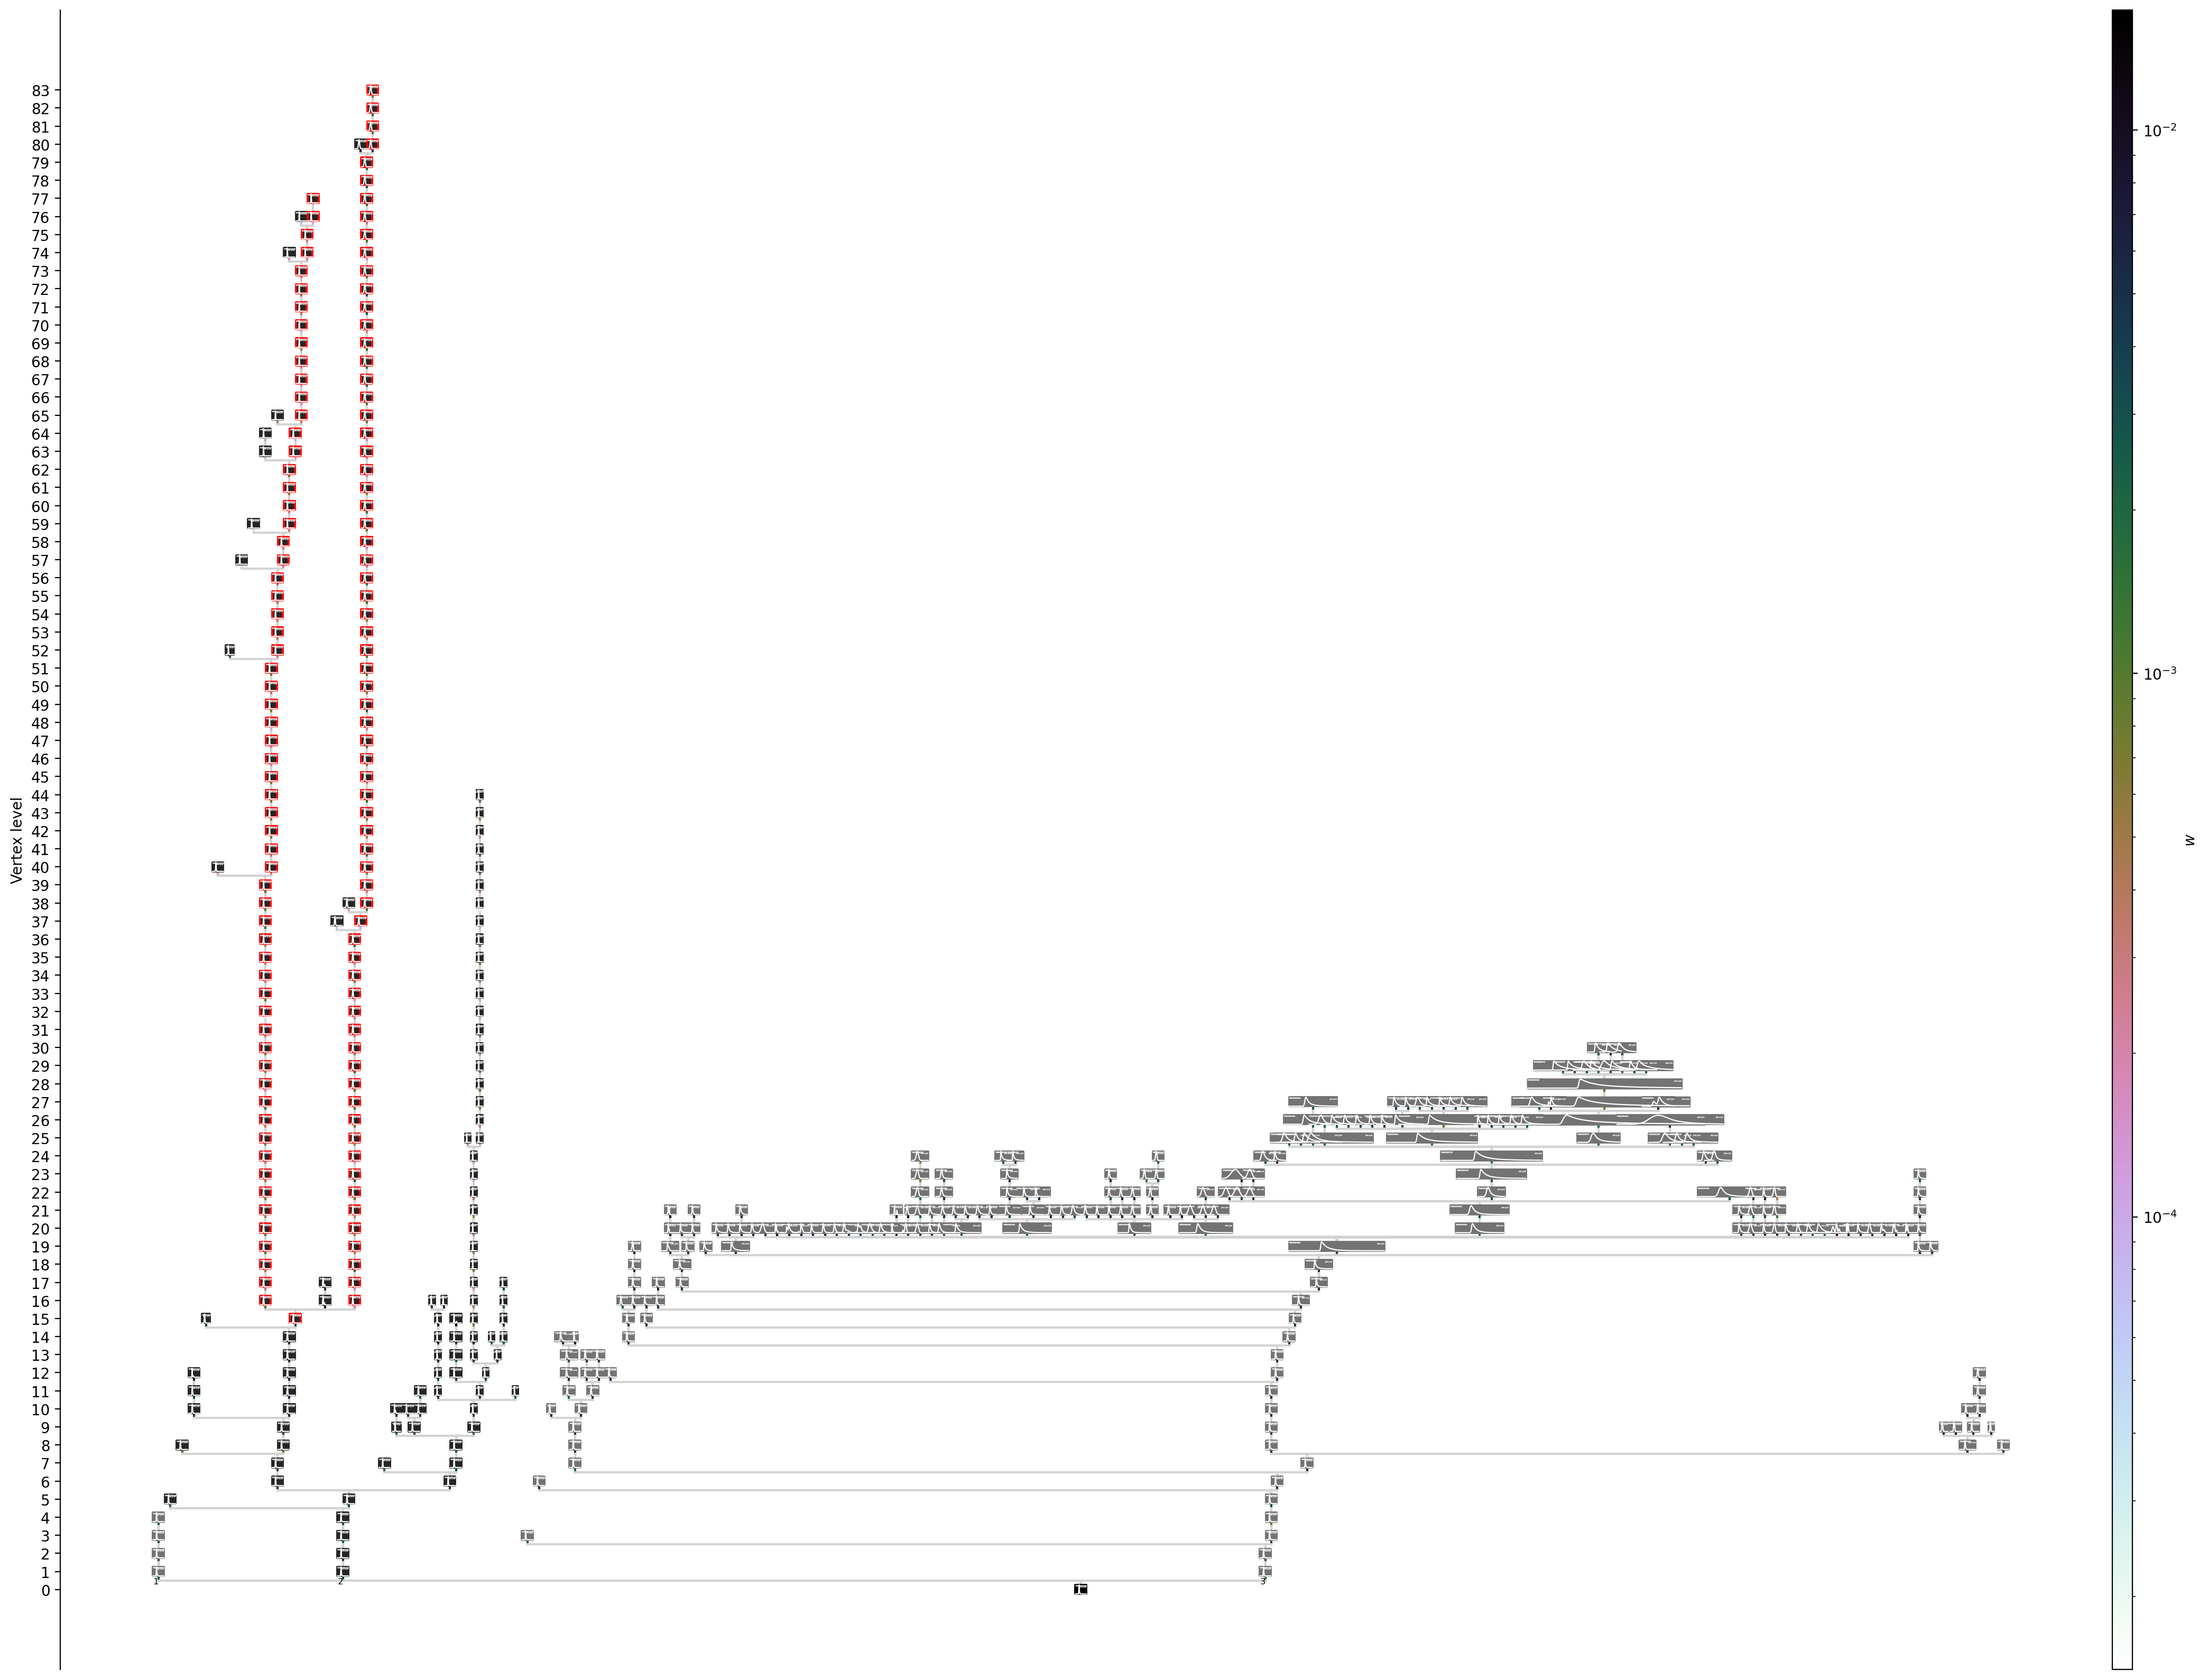

In [14]:
phase_thres = 1

freqs_filename = {0: u'0-200MHz', # in MHz
                  1: u'200-400MHz',
                  2: u'400-700MHz',
                  3: u'700-1000MHz',
                  4: u'1000-1500MHz',
                  5: u'1500-2000MHz',
                  6: u'2000+MHz'}

palette = {
    0: '#490A3D',
    1: '#BD1550',
    2: '#E97F02',
    3: '#F8CA00',
    4: '#8A9B0F',
    
} # https://www.colourlovers.com/palette/848743/(_”_)

palette = {i:c for i, c in enumerate(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', 
                                      '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', 
                                      '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']) } # https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12

palette_rankin_class = {i:c for i, c in enumerate(
        [
#             '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00'
#             '#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'
            # '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99'  # Goodish
            # '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00'
            # '#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666'
            '#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae','#f1e2cc','#cccccc'
            # '#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec'  #pastel
            # '#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3'
            # '#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5'
            # '#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4'
            # '#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'
            # '#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17','#666666'
        ]
    ) 
}

base_color = 'white' if colour_by != 'rankin_class' else 'black'
data_color = blue_full if colour_by != 'rankin_class' else pink
annotation_color = 'white' if colour_by != 'rankin_class' else 'black'
# palette = {i:c for i, c in enumerate(['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', 
#                                       '#80b1d3', '#fdb462', '#b3de69', '#fccde5']) } # https://colorbrewer2.org/#type=qualitative&scheme=Set3&n=8 

# palette = {i:c for i, c in enumerate(
#     ['#ffffff', '#fdbf6f', '#f0f0f0', '#bdbdbd', '#d9d9d9', 
#      '#737373', '#969696', '#525252', '#252525'][::-1]
# )} # https://colorbrewer2.org/#type=sequential&scheme=Greys&n=8

palette = {i:c for i, c in enumerate(
    ['#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373',
     '#252525', '#737373', 
     '#252525', '#737373', 
     '#000000'][::-1]
)} # https://colorbrewer2.org/#type=sequential&scheme=Greys&n=8

morphological_classes = np.array([p.morphological_class for p in goodies_pop.as_array()])
morphological_codes = np.array([p.morphological_code for p in goodies_pop.as_array()])

palette_morph_class = {
    # c:palette_rankin_class[i] for i, c in enumerate(
    #     np.unique(morphological_classes[(morphological_classes != 'N/A')])
    # )
    'Core single': palette_rankin_class[0],
    'Conal single': palette_rankin_class[1],
    'Conal double': palette_rankin_class[2],
    'Triple': palette_rankin_class[3],
    'Multiple': palette_rankin_class[4],
}
palette_morph_class['N/A'] = '#000000'

# print ('palette_morph_class', palette_morph_class.keys())

# palette_morph_code = {
#     c:palette_rankin_class[i] for i, c in enumerate(
#         np.unique(morphological_codes[morphological_codes != 'nan'])
#     )
# }


# Prediction section
def predict(population, k, neighbours, mst):
    def del_na(_classes:list):
        where_na = lambda _classes: (c == 'N/A' for c in _classes)
        for i, d in enumerate(where_na(_classes)):
            if d:
                del _classes[i]
        return _classes
    
    def majority(classes, verbose=False):
        # u: unique classes, c: unique counts
        u, c = np.unique(classes, return_counts=True)
        uu, cc = np.unique(c, return_counts=True)
#         print (uu, c)
        if cc[np.where(uu == np.max(c))] == 1:
            maj = u[np.argmax(c)]
            if verbose:
                print (maj)
        else:
            maj = None
            if verbose:
                print ('No majority')
        return maj
    
#     classes = del_na([population.as_array()[c].morphological_class for c in neighbours[k]])
#     for c in neighbours[k]:
#         population.as_array()[c].predicted_class = 'N/A'
    classes = del_na([population.as_array()[c].morphological_class \
               if population.as_array()[c].morphological_class != 'N/A' \
               else population.as_array()[c].predicted_class \
               for c in neighbours[k]])
    
    # print (len(classes), classes)

    if len(classes) > 0:
        if majority(classes) is not None:
            return majority(classes)
            # print (k, majority(classes))
        else:
            # find nearest neighbour
            nn = neighbours[k][np.argmin([get_weight(mst, k, c) for c in neighbours[k]])]
            return population.as_array()[nn].morphological_class
    else:
        nn = neighbours[k][np.argmin([get_weight(mst, k, c) for c in neighbours[k]])]
        return population.as_array()[nn].morphological_class

# Main code
initialized = True if 'initialized' in globals() else False
if not initialized:
    # Initialize all when needed... 
    for i in range(len(goodies_pop.as_array())):
        goodies_pop.as_array()[i].predicted_class = 'N/A'
    initialized = True
    
x_coords, y_coords, pulsars, facecolors, edgecolors = [], [], [], [], []
for k in node_coordinates.keys():
    x_coords.append(node_coordinates[k][0]) 
    y_coords.append(node_coordinates[k][1]) 
    kk = k if not contracted else contracted_mst_indices[k]
    pulsars.append(goodies_pop.as_array()[kk])
    
    if goodies_pop.as_array()[kk].morphological_class != 'N/A':
        predicted = False
        morphological_class = goodies_pop.as_array()[kk].morphological_class 
    else:
        predicted = True
        morphological_class = predict(goodies_pop, kk, neighbours, mst)
        # print (morphological_class)
        goodies_pop.as_array()[kk].predicted_class = morphological_class
        # print(goodies_pop.as_array()[kk].jname, 
        #       goodies_pop.as_array()[kk].bname,  
        #       goodies_pop.as_array()[kk].predicted_class)
        
    if  colour_by == 'branch':
        facecolors.append(palette[node_coordinates[k][2]])
        edgecolors.append('red' if kk in mst.longest_path else palette[node_coordinates[k][2]])
    else: # assumes there are only two  cases...
        facecolors.append(palette_morph_class[morphological_class])
        edgecolors.append('dimgrey' if predicted else 'red' \
                          if kk in mst.longest_path else palette_morph_class[morphological_class])
        
    
_x = 10.5 if len(goodies_pop.as_array()) < 100 else 21
_y = 8 if len(goodies_pop.as_array()) < 100 else 16

fontsize = 1.1 if len(goodies_pop.as_array()) < 100 else 0.1
profile_linewidth = .2 if _cond_ else 0.8
connection_linewidth = 1.5

if contracted:
    _x = 10.5
    _y = 5
    fontsize = 1.5



fig = plt.figure(figsize=(_x, _y))
_ax = axes_grid1.AxesGrid(fig, 111,
                          nrows_ncols=(1, 1),
                          axes_pad=0.05,
                          cbar_mode='single',
                          cbar_location='right',
                          cbar_pad=0.1,
                          cbar_size="1%",
                          aspect=False)

ax = _ax[0]

y_box_height = 0.5 / 2 if len(goodies_pop.as_array()) != 2 else 0.5 

top_cond = np.where((y_coords == np.max(y_coords)))[0][0]
max_y_top_level = y_coords[top_cond]
min_x_top_level = x_coords[top_cond]
min_x = np.min(x_coords)


multi_names_to_annotate = [
    # Leaves
    'J2321+6024', 'J2113+4644', #'J1740+1311', J0332+5434', 
    # Level 1
    'J2219+4754', 'J1820-0427', 'J1917+1353', 
    'J1607-0032', 'J2055+3630', 'J0629+2415']
multi_annotation = {
    # Leaves
    'J2321+6024': {'text':'a', 'location':'top', 'color':'black'}, 
    'J2113+4644': {'text':'b', 'location':'top', 'color':'black'}, 
    # 'J0332+5434': {'text':'', 'location':'top', 'color':'black'}, 
    # Level 1
    'J2219+4754': {'text':'6', 'location':'left_to_edge', 'color':'black'}, 
    'J1820-0427': {'text':'5', 'location':'left_to_edge', 'color':'black'}, 
    'J1917+1353': {'text':'4', 'location':'left_to_edge', 'color':'black'}, 
    'J1607-0032': {'text':'3', 'location':'left_to_edge', 'color':'black'}, 
    'J2055+3630': {'text':'2', 'location':'left_to_edge', 'color':'black'}, 
    'J0629+2415': {'text':'1', 'location':'left_to_edge', 'color':'black'}
}

single_names_to_annotate = [
    # Level 1
    'J1607-0032', 
    'J1917+1353', 
    'J1822-2256',
    'J2313+4253',
    'J1820-0427',
    'J2219+4754',
    'J2354+6155',
    'J2055+3630']
single_annotation = {
    # Level 1
    'J1607-0032': {'text':'1', 'location':'left_to_edge'}, 
    'J1917+1353': {'text':'2', 'location':'left_to_edge'}, 
    'J1822-2256': {'text':'3', 'location':'left_to_edge'},
    'J2313+4253': {'text':'4', 'location':'left_to_edge'},
    'J1820-0427': {'text':'5', 'location':'left_to_edge'},
    'J2219+4754': {'text':'6', 'location':'left_to_edge'},
    'J2354+6155': {'text':'7', 'location':'left_to_edge'},
    'J2055+3630': {'text':'8', 'location':'left_to_edge'}
}


for pulsar, x, y, facecolor, edgecolor in zip(pulsars, x_coords, y_coords, facecolors, edgecolors):
    for i, (yy, f) in enumerate(
        zip(
            [y_box_height/2, 0, -y_box_height/2, -y_box_height] if len(freq_ids_to_include) == 4 else [-y_box_height],
            freq_ids_to_include
        )):
        if _cond_:
            phase = pulsar.observations[f].phase[cond]
            if plot_stokes_I:
                profile = pulsar.observations[f].stokes_I[cond]
            if plot_polarization:
                stokes_V = pulsar.observations[f].stokes_V[cond]
                stokes_L = pulsar.observations[f].stokes_L[cond]
            if plot_pa:
                try:
                    cond_pa = np.where(np.abs(pulsar.observations[f].position_angle_phase) < phase_thres)
                    pa = pulsar.observations[f].position_angle[cond_pa]
                    pa_err = pulsar.observations[f].position_angle_yerr_high[cond_pa]
                    pa_phase = pulsar.observations[f].position_angle_phase[cond_pa]
                except TypeError:
                    pa = None
                
            model = pulsar.observations[f].model[cond]
        else:
            phase = pulsar.observations[f].phase
            if plot_stokes_I:
                profile = pulsar.observations[f].stokes_I
            if plot_polarization:
                stokes_V = pulsar.observations[f].stokes_V
                stokes_L = pulsar.observations[f].stokes_L
            if plot_pa:
                try:
                    pa = pulsar.observations[f].position_angle
                    pa_err = pulsar.observations[f].position_angle_yerr_high
                    pa_phase = pulsar.observations[f].position_angle_phase
                except TypeError:
                    pa = None
                    
            model = pulsar.observations[f].model

        if i == 0:
            ax.fill_between(
                np.linspace(x - phase.size / 2, 
                            x + phase.size / 2,
                            phase.size),
                y - y_box_height,
                y + y_box_height,
                facecolor=facecolor,
                edgecolor=edgecolor,
                lw=1.4 if not contracted else 2.6,
                alpha=1,
                zorder=100
            )

        txt = ax.text(#x, y,
                 x - phase.size / 2 + x_scaler*0.005, 
                 y + y_box_height + (y_box_height/30), 
                 "%s" % (pulsar.jname),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=fontsize, 
                 c=annotation_color, 
                 zorder=500)
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.25, foreground='#ffffff88')])
        
        # Annotation (Top)
        if annotate:
            if len(freq_ids_to_include) == 1:
                if pulsar.jname in single_names_to_annotate:
                    if single_annotation[pulsar.jname]['location'] == 'top':
                        txt = ax.text(#x, y,
                                x - phase.size / 2 + x_scaler*0.25, 
                                y + y_box_height + (1.5 * y_box_height), 
                                "%s" % (single_annotation[pulsar.jname]['text']),
                                horizontalalignment='center',
                                verticalalignment='top',
                                fontsize=20, 
                                c=annotation_color, 
                                zorder=500)
                        txt.set_path_effects([PathEffects.withStroke(linewidth=0.25, foreground='#ffffff88')])
            else:
                if pulsar.jname in multi_names_to_annotate:
                    if multi_annotation[pulsar.jname]['location'] == 'top':
                        txt = ax.text(#x, y,
                                x - phase.size / 2 + x_scaler*0.25, 
                                y + y_box_height + (1.5 * y_box_height), 
                                "%s" % (multi_annotation[pulsar.jname]['text']),
                                horizontalalignment='left',
                                verticalalignment='top',
                                fontsize=12, 
                                c=multi_annotation[pulsar.jname]['color'], 
                                zorder=500)
                        txt.set_path_effects([PathEffects.withStroke(linewidth=0.25, foreground='#ffffff88')])

        if print_bname:
            txt = ax.text(#x, y,
                     x - phase.size / 2 + x_scaler*0.005, 
                     y + y_box_height - (y_box_height/10), 
                     "%s" % (pulsar.bname),
                     horizontalalignment='left',
                     verticalalignment='top',
                     fontsize=fontsize, 
                     c=annotation_color, 
                     zorder=500)
            txt.set_path_effects([PathEffects.withStroke(linewidth=0.25, foreground='#ffffff88')])
        txt = ax.text(#x, y,
                 x + phase.size / 2 + x_scaler*0.075, 
                 y + y_box_height + (y_box_height/30), 
                 "$\phi\in\pm%.1f$" % (phase_thres),
                 horizontalalignment='right',
                 verticalalignment='top',
                 fontsize=fontsize, 
                 c=annotation_color, 
                 zorder=500)
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.25, foreground='#ffffff88')])
        
        if colour_by != 'branch':
            txt = ax.text(#x, y,
                     x + phase.size / 2  + x_scaler*0.005, 
                     y + y_box_height - (y_box_height/10), 
                     "$%s$" % (pulsar.morphological_code),
                     horizontalalignment='right',
                     verticalalignment='top',
                     fontsize=fontsize, 
                     c=annotation_color, 
                     zorder=500)
            txt.set_path_effects([PathEffects.withStroke(linewidth=0.25, foreground='#ffffff88')])
            
        ax.plot(
            np.linspace(x - phase.size / 2, 
                        x + phase.size / 2, 
                        phase.size
            ), 
            (model * (0.1 if _4freqs_ else 0.5)) + y + yy,
            linewidth=profile_linewidth,
            zorder=600,
            color=base_color
        )

        if plot_stokes_I:
            ax.plot(
                np.linspace(x - phase.size / 2, 
                            x + phase.size / 2, 
                            phase.size
                ), 
                ((profile - pulsar.observations[f].central) * (0.1 if _4freqs_ else 0.5)) + y + yy,
                linewidth=profile_linewidth,
                zorder=700,
                color=data_color,
                linestyle=':'
            )  
        
        if plot_polarization:
            ax.plot(
                np.linspace(x - phase.size / 2, 
                            x + phase.size / 2, 
                            phase.size
                ), 
                (stokes_L * (0.1 if _4freqs_ else 0.5)) + y + yy,
                linewidth=profile_linewidth,
                zorder=100,
                color=pink
            )

            ax.plot(
                np.linspace(x - phase.size / 2, 
                            x + phase.size / 2, 
                            phase.size
                ), 
                (stokes_V * (0.1 if _4freqs_ else 0.5)) + y + yy,
                linewidth=profile_linewidth,
                zorder=100,
                color=blue_full
            )
            
        if plot_pa:
            if pa is not None:
                ax.errorbar(x + (pa_phase*phase.size)/(np.abs(phase.max())+np.abs(phase.min())), 
                             (((pa + 90) / 180) * (0.1 if _4freqs_ else 0.5)) + y + yy, 
                             yerr=(pa_err / 180) * (0.1 if _4freqs_ else 0.5),
                             fmt='.',
                             capthick=0.1,
                             color='#F8BA00',
                             ms=0.01,
                             ecolor='#F8BA00',
#                              marker=None,
#                              ms=0.001,
#                              mfc='black',
                             elinewidth=profile_linewidth,
#                              markersize=0.5,
#                              color=base_color,
                             zorder=500)
        
            
#         if x == min_x_top_level and y == max_y_top_level:
#             print ('in')
#             # Plot zoomed in section
#             axins.plot(
#                 phase, 
#                 (profile * (0.1 if _4freqs_ else 0.5)) + y + yy,
# #                 linewidth=profile_linewidth,
# #                 zorder=200,
#                 color='black'
#             )
#             # sub region of to be zoomed
#             x1 = x - phase.size / 2
#             x2 = x + phase.size / 2
#             y1 = y - y_box_height - 0.5
#             y2 = y + y_box_height
#             print (x1, x2, y1, y2)
#             print ()
#             axins.set_xlim(x1, x2)
#             axins.set_ylim(y1, y2)
            
    

for c in connections['parent']:
    ax.plot(c[0], c[1], 
            c='lightgrey',
            alpha=1,
            linewidth=connection_linewidth,
            zorder=50)

_distances, _cumulative_distances = [], []
for c in connections['child']:
    _distances.append(c[-3])
    _cumulative_distances.append(c[-1])

_distances = np.array(_distances)
_cumulative_distances = np.array(_cumulative_distances)

# norm = colors.Normalize(vmin=0, vmax=_distances.max())  
norm = colors.LogNorm(vmin=np.nanmin(_distances), vmax=np.nanmax(_distances[np.where(_distances != np.inf)[0]]))


# norm = colors.LogNorm(vmin=_cumulative_distances.min(), vmax=_cumulative_distances.max())

if annotate:
    b_n = 1
for c in connections['child']:
    # print (c[-3], np.nanmin(_distances), np.nanmax(_distances[np.where(_distances != np.inf)[0]]))
    ax.plot(c[0], c[1], 
            c=cmap(norm(c[-3])), 
            linewidth=connection_linewidth,
            zorder=10)

    # Annotation
    if annotate:
        if c[-1] == 1:
            ax.text(#x, y,
                    c[0][0] - phase.size / 2, 
                    c[1][1] - 1.295 * (c[1][1]-c[1][0])/2, 
                    "%s" % (b_n),
                    horizontalalignment='left',
                    verticalalignment='top',
                    fontsize=6, 
                    c='black', 
                    zorder=500)
            b_n += 1

ax.set_yticks(np.arange(np.unique(levels).min(), 
                        np.unique(levels).max()+1, 
                        1.0))
ax.set_ylabel('Vertex level')
ax.axes.xaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ax.cbar_axes[0].colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    label=u'$w$', 
)

if colour_by != 'branch':
    for i, k in enumerate(palette_morph_class.keys()):
        txt = ax.text(0.01, 0.95 - (0.05 * i), 
                '%s' % (k),
                color=palette_morph_class[k],
                horizontalalignment='left',
                verticalalignment='center',
                transform=ax.transAxes)
        if k != 'N/A':
            txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

plt.tight_layout()

s_p = step_pattern if type(step_pattern) == str else 'rabinerJuang'

if colour_by == 'branch':
    if _4freqs_:
        if not contracted:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/tree_sequence_4freqs_phase_%s_%s_%s' % (phase_thres, s_p, stokes_to_include[0])
            else:
                filename = 'images/tree_sequence_4freqs_full_phase_%s_%s' % (s_p, stokes_to_include[0])
        else:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/contr_tree_sequence_4freqs_phase_%s_%s_%s' % (phase_thres, s_p, stokes_to_include[0])
            else:
                filename = 'images/contr_tree_sequence_4freqs_full_phase_%s_%s' % (s_p, stokes_to_include[0])
    else:
        if not contracted:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/tree_sequence_%s_phase_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                          phase_thres, 
                                                                          s_p, stokes_to_include[0])
            else:
                filename = 'images/tree_sequence_%s_full_phase_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                           step_pattern, stokes_to_include[0])
        else:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/contr_tree_sequence_%s_phase_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                          phase_thres, 
                                                                          s_p, stokes_to_include[0])
            else:
                filename = 'images/contr_tree_sequence_%s_full_phase_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                           step_pattern, stokes_to_include[0])

if colour_by == 'rankin_class':
    if _4freqs_:
        if not contracted:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/tree_sequence_4freqs_phase_%s_%s_%s_%s' % (phase_thres, s_p, stokes_to_include[0], colour_by)
            else:
                filename = 'images/tree_sequence_4freqs_full_phase_%s_%s_%s' % (s_p, stokes_to_include[0], colour_by)
        else:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/contr_tree_sequence_4freqs_phase_%s_%s_%s_%s' % (phase_thres, s_p, stokes_to_include[0], colour_by)
            else:
                filename = 'images/contr_tree_sequence_4freqs_full_phase_%s_%s_%s' % (s_p, stokes_to_include[0], colour_by)
    else:
        if not contracted:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/tree_sequence_%s_phase_%s_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                          phase_thres, 
                                                                          s_p, stokes_to_include[0], colour_by)
            else:
                filename = 'images/tree_sequence_%s_full_phase_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                           step_pattern, stokes_to_include[0], colour_by)
        else:
            if _cond_:
                print ("%s" % phase_thres)
                filename = 'images/contr_tree_sequence_%s_phase_%s_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                          phase_thres, 
                                                                          s_p, stokes_to_include[0], colour_by)
            else:
                filename = 'images/contr_tree_sequence_%s_full_phase_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                           step_pattern, stokes_to_include[0], colour_by)
                
# plt.savefig(filename + '_%s.png' % state_prefix, dpi=250)
plt.savefig(filename + '_%s.pdf' % state_prefix)
print (filename)



In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(np.sort(_cumulative_distances), label='cumulative w from root')
ax.plot(np.sort(_distances), label='w')
ax.set_xlabel('i')
ax.set_ylabel(r'Distance ($w$)')
ax.legend()
plt.tight_layout()
if _4freqs_:
    if _cond_:
        print ("%s" % phase_thres)
        filename = 'images/weights_4freqs_phase_%s_%s_%s' % (phase_thres, s_p, stokes_to_include[0])
    else:
        filename = 'images/weights_4freqs_full_phase_%s_%s' % (s_p, stokes_to_include[0])
else:
    if _cond_:
        print ("%s" % phase_thres)
        filename = 'images/weights_%s_phase_%s_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                  phase_thres, 
                                                                  s_p, stokes_to_include[0])
    else:
        filename = 'images/weights_%s_full_phase_%s_%s' % (freqs_filename[freq_ids_to_include[0]], 
                                                                   step_pattern, stokes_to_include[0])

# plt.savefig(filename + '_%s.png' % state_prefix, dpi=250)
plt.savefig(filename + '_%s.pdf' % state_prefix)

In [40]:
from astropy.visualization import hist
from astropy.stats import histogram

rc('font', size=14)
rc('axes', titlesize=18)
rc('axes', labelsize=16)

vertex_u = np.array(mst.mst).T[0]
vertex_v = np.array(mst.mst).T[1]
dists = np.array(mst.mst).T[-1]
# dists = np.sort(_cumulative_distances)

fig, ax = plt.subplots(1, 1) #,  figsize=(12,4))

_ax = ax
for bins in ['knuth']: #, 'knuth', 'blocks']:
    h = hist(dists, bins=bins,  histtype='stepfilled', density=True, alpha=0.25, color='grey', ax=_ax)
    _ax.set_xlabel('$w$')
    _ax.set_ylabel('P($w$)')

    y, _x = h[0]/h[0].sum(), h[1]
    x  = np.array([np.mean([_x[i],_x[i+1]]) for i in range(_x[:-1].size)])
    model = lmfit.models.PowerLawModel()
    fit = model.fit(y, x=x)
    _ax.plot(x, 
             fit.params['amplitude'] * x**fit.params['exponent'], 
#              color='orange', 
#              linestyle='--',
             label=r'''%s
             $\alpha=%.1f \pm %.2f$
             $k=%.1f\pm%.2f$''' % (
                 bins,
                 fit.params['exponent'].value,
                 fit.params['exponent'].stderr,
                 fit.params['amplitude'].value,
                 fit.params['amplitude'].value,
             )
            )
    
    dist = np.array([d/dists.sum() for d in dists])
    H = -np.sum(dist * np.log(dist))
    _ax.axvline(H)
    
_ax.legend(fontsize=12)


# _ax.annotate('MST', xy=(1, 1),  xycoords='data',
#             xytext=(1, 1), textcoords='axes fraction',)
# _ax.set_xscale('log')

plt.tight_layout()
if len(freq_ids_to_include) > 1:
    plt.savefig('images/mst_multifreq_hist_w.pdf')
else:
    plt.savefig('images/mst_1000-1500_hist_w.pdf')
# hist(dists, bins='blocks',  histtype='stepfilled', density=True, color='black', ax=ax[1])

AttributeError: module 'typing_extensions' has no attribute 'OrderedDictTypedDict'

In [ ]:
def plot_histogram(dist, bins='knuth', fitting=False, return_hist=False, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    counts, bins = histogram(dists, bins=bins)

    # Normalize counts
    counts = counts/counts.sum()

    # recover
    centroids = (bins[1:] + bins[:-1]) / 2
    counts_, bins_, _ = ax.hist(centroids, 
                                 bins=len(counts),
                                 weights=counts, 
                                 range=(min(bins), 
                                        max(bins)),
                                 edgecolor=blue_full, 
                                 linewidth=1.2,
                                 color=base_color,
                                 label=label,
                                 alpha=.5
                                )
    
    if fitting:
        x  = np.array([np.mean([bins[i],bins[i+1]]) for i in range(_x[:-1].size)])
        model = lmfit.models.PowerLawModel()
        fit = model.fit(counts, x=x)
        ax.plot(x, 
                fit.params['amplitude'] * x**fit.params['exponent'], 
                label=r'''$\alpha=%.1f \pm %.2f$
    $k=%.1f\pm%.2f$''' % (
                 fit.params['exponent'].value,
                 fit.params['exponent'].stderr,
                 fit.params['amplitude'].value,
                 fit.params['amplitude'].value,
                )
               )

    ax.set_xlabel(r'$w$')
    ax.set_ylabel(r'$P(w)$', color=blue_full)
    
    if return_hist:
        return ax, bins, counts
    else:
        return ax

def plot_information(dist, bins, counts, ax=None, verbose=False):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    counts[counts == 0] = 1e-19
    ax2 = ax.twinx()
    info = []
    
    sorted_dist = np.sort(dist)

    if verbose:
        print ('d, b0, b1, p, _info')
    for d in sorted_dist:
        searching = True
        for i, b in enumerate(bins[1:]):
            if searching:
                if d <= b:
                    p = counts[i]
                    _info = -np.log2(p)
                    if verbose:
                        print ('%.2f, %.2f, %.2f, %.2f, %.2f' % (d, bins[i-1 if i > 0 else i], b, p, _info))
                    info.append(_info)
                    searching = False
                    
    info = np.array(info)
    ax2.scatter(sorted_dist, info, marker='+', label='info', color=pink, alpha=.5)
    ax2.set_ylabel(r'$I(w)$', color=pink)
#     ax2.set_yscale('log')
    return ax, ax2, info

def entropy(dist, kde=None):
    if kde is None:
        kde = gaussian_kde(dist)
    return -np.sum(kde.pdf(dist) * kde.logpdf(dist))

# def redundancy(dist, entropy):
    

def plot_kde(dist, ax=None, ax2=None, verbose=False):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    kde = gaussian_kde(dist)
    
    # Plot PDF
    ax.plot(dist, kde.pdf(dist), color=blue_full)
    ax.set_ylabel(r'$P(w)$', color=blue_full)
    
    # Plot info
    if ax2 is None:
        ax2 = ax.twinx()
        
    info = -kde.logpdf(dist)
    _entropy = -np.sum(kde.pdf(dist) * kde.logpdf(dist))
    _redundancy = 1 - (_entropy / np.log(dist.shape[0]))
    
    print (_entropy, np.log(dist.shape[0]))
    
    central = np.median(info)
#     cut  = np.where(info <= central)[0][-1]
#     for i, color in enumerate(['grey', pink]):
#         if i == 0:
#             ax2.scatter(dist[0:cut], info[0:cut], color=color, marker='+')
#         else: 
#             ax2.scatter(dist[cut:-1], info[cut:-1], color=color, marker='+')

    cut  = np.where(info <= central)[0]
    keep = np.where(info > central)[0]
    print (cut)
    for i, color in enumerate(['grey', pink]):
        if i == 0:
            ax2.scatter(dist[cut], info[cut], color=color, marker='+')
        else: 
            ax2.scatter(dist[keep], info[keep], color=color, marker='+')
            
    ax2.axhline(central, color='grey', alpha=0.25, linestyle='--', zorder=1000)
            
    ax2.set_ylabel(r'$I(w)$', color=pink)
    
#     ax2.text(0.95, 0.55, 
#              'H(W)=%.2f' % _entropy,
#              horizontalalignment='right',
#              verticalalignment='center',
#              transform=ax2.transAxes)
    
#     ax2.text(0.95, 0.45, 
#              'R(W)=%.2f' % _redundancy,
#              horizontalalignment='right',
#              verticalalignment='center',
#              transform=ax2.transAxes)

#     ax2.plot(dist, info, color=blue_full)
#     ax2.axhline(central, color='black')
#     ax2.axvline(dist[np.where(info <= central)[0][-1]], 
#                 color='black')

    return ax, ax2, kde, cut

vertex_u = np.array(mst.mst).T[0]
vertex_v = np.array(mst.mst).T[1]
dists = np.array(mst.mst).T[-1]

# Main
counts, bins = histogram(dists, bins='knuth')

rc('font', size=14)
rc('axes', titlesize=18)
rc('axes', labelsize=16)

ax, bins, counts = plot_histogram(dists, bins='knuth', return_hist=True)
# ax, ax2, info = plot_information(dists, bins, counts, ax=ax, verbose=False)
ax2 = None
ax, ax2, kde, cut = plot_kde(dists, ax=ax, ax2=ax2, verbose=False)

# ax.axhline(10**0, color='black', alpha=0.7, linestyle=':')

plt.tight_layout()
print (freq_ids_to_include)
if len(freq_ids_to_include) > 1:
    plt.savefig('images/mst_multifreq_hist_w.pdf')
else:
    plt.savefig('images/mst_1000-1500_hist_w.pdf')


In [ ]:
#
# Edges contraction
#
def get_mst_line_index(mst, u, v):
    _mst = np.array(mst)
    return int(
        np.where(
            ((_mst.T[0] == u) & (_mst.T[1] == v)) | ((_mst.T[0] == v) & (_mst.T[1] == u))
        )[0]
    )

def edge_contraction(u, root, mst, contraction_set, children, w=0, verbose=False):
    def get_jname(idx):
        return goodies_pop.as_array()[idx].jname
    
#     if verbose:
#         print (u, 'c:', children[u])
#         print (get_jname(u), 'c:', [get_jname(c) for c in children[u]])
#         print ()
    
    for v in children[u]:
        idx = get_mst_line_index(mst, u, v)
        
        if v in contraction_set:
            if verbose:
                print ('deleting (%d, %s),' % (v, get_jname(v) if mst[idx][0] == u else get_jname(u)),
                       mst[idx])
            del mst[idx]
            
        if v not in contraction_set and u in contraction_set:
            # Update w by adding parent's w
#             if verbose:
#                 print ('before:', get_jname(mst[idx][0]), get_jname(mst[idx][1]), mst[idx][2])
#                 print ('before:', mst[idx])
            mst[idx][2] += w
            # Update u to root
            if mst[idx][0] == u:
                mst[idx][0] = root
            else: 
                mst[idx][1] = root
#             if verbose:
#                 print ('after:', get_jname(mst[idx][0]), get_jname(mst[idx][1]), mst[idx][2])   
#                 print ('after:', mst[idx])   s
        
        # Vist child
        edge_contraction(v, 
                         root if v in contraction_set else v, 
                         mst, 
                         contraction_set, 
                         children, 
                         w + mst[idx][2] if v in contraction_set else 0,
                         verbose=verbose)
        
        # In case the id changed in the meantime?
#         idx = get_mst_line_index(mst, u, v)
        
                              
        if verbose:
            print ()
        
def reindex(mst:list):
    nmst = np.array(mst)
    U = np.unique(np.concatenate([nmst.T[0], 
                                  nmst.T[1]])).astype('int')
    mst_contracted_indices = {}
    contracted_mst_indices = {}
    
    for i in range(U.shape[0]):
        mst_contracted_indices[U[i]] = i
        contracted_mst_indices[i] = U[i]
    
    for i in range(len(mst)):
        mst[i] = [
            mst_contracted_indices[mst[i][0]],
            mst_contracted_indices[mst[i][1]],
            mst[i][2],
        ]
    
    return mst, mst_contracted_indices, contracted_mst_indices


# contraction_set = np.unique([vertex_u[:cut], vertex_v[:cut]]).astype('int')
contraction_set = np.unique([vertex_u[cut], vertex_v[cut]]).astype('int')
# print (contraction_set)
root = mst.centrality.argmax()
_mst = copy.deepcopy(mst.mst)

edge_contraction(root, root, mst.mst, contraction_set, children, w=0, verbose=False)

mst.mst, mst_contracted_indices, contracted_mst_indices = reindex(mst.mst)
mst.compute_closeness_centrality()

# U = np.unique(np.concatenate([np.array(_mst).T[0], np.array(_mst).T[1]]))
# _mst_ = copy.deepcopy(np.array(mst.mst))
# for i in range(U.size):
#     _mst_[np.array(mst.mst).T[0] == np.where(U[i])] = i
    
contracted = True
plot_polarization = False
annotate = False

In [ ]:
print (len(_mst), len(mst.mst))

In [ ]:
contracted_mst_indices

In [ ]:
# Single pulsar panel for cartoon

In [ ]:
multi_names_to_annotate = [
    # Leaves
    'J1740+1311', 'J0332+5434', 
    # Level 1
    'J2219+4754', 'J1820-0427', 'J1917+1353', 
    'J1607-0032', 'J2055+3630', 'J0629+2415']
multi_annotation = {
    # Leaves
    'J1740+1311': {'text':'a', 'location':'top'}, 
    'J0332+5434': {'text':'b', 'location':'top'}, 
    # Level 1
    'J2219+4754': {'text':'6', 'location':'left_to_edge'}, 
    'J1820-0427': {'text':'5', 'location':'left_to_edge'}, 
    'J1917+1353': {'text':'4', 'location':'left_to_edge'}, 
    'J1607-0032': {'text':'3', 'location':'left_to_edge'}, 
    'J2055+3630': {'text':'2', 'location':'left_to_edge'}, 
    'J0629+2415': {'text':'1', 'location':'left_to_edge'}
}


for pulsar, x, y, facecolor, edgecolor in zip(pulsars, x_coords, y_coords, facecolors, edgecolors):
    if pulsar.jname in ['J2219+4754', 'J1740+1311', 'J0332+5434', 'J1645-0317', 'J1136+1551']:
        fig, ax = plt.subplots(1,1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        for i, (yy, f) in enumerate(
            zip(
                [y_box_height/2, 0, -y_box_height/2, -y_box_height] if len(freq_ids_to_include) == 4 else [-y_box_height],
                freq_ids_to_include
            )):
            if _cond_:
                phase = pulsar.observations[f].phase[cond]
                if plot_stokes_I:
                    profile = pulsar.observations[f].stokes_I[cond]
                if plot_polarization:
                    stokes_V = pulsar.observations[f].stokes_V[cond]
                    stokes_L = pulsar.observations[f].stokes_L[cond]
                model = pulsar.observations[f].model[cond]
            else:
                phase = pulsar.observations[f].phase
                if plot_stokes_I:
                    profile = pulsar.observations[f].stokes_I
                if plot_polarization:
                    stokes_V = pulsar.observations[f].stokes_V
                    stokes_L = pulsar.observations[f].stokes_L
                model = pulsar.observations[f].model

            if i == 0:
                ax.fill_between(
                    np.linspace(- phase.size / 2, 
                                + phase.size / 2,
                                phase.size),
                    - y_box_height,
                    + y_box_height,
                    facecolor=facecolor,
                    edgecolor=edgecolor,
                    lw=1.4 if not contracted else 2.6,
                    alpha=1,
                    zorder=100
                )

            ax.text(#x, y,
                     - phase.size / 2 + x_scaler*0.005, 
                     + y_box_height + (y_box_height/30), 
                     "%s" % (pulsar.jname),
                     horizontalalignment='left',
                     verticalalignment='top',
                     fontsize=fontsize, 
                     c=base_color, 
                     zorder=500)

            # Annotation (Top)
            if annotate:
                if len(freq_ids_to_include) == 1:
                    if pulsar.jname in single_names_to_annotate:
                        if single_annotation[pulsar.jname]['location'] == 'top':
                            ax.text(#x, y,
                                    - phase.size / 2 + x_scaler*0.25, 
                                    + y_box_height + (1.5 * y_box_height), 
                                    "%s" % (single_annotation[pulsar.jname]['text']),
                                    horizontalalignment='center',
                                    verticalalignment='top',
                                    fontsize=20, 
                                    c=annotation_color, 
                                    zorder=500)
                else:
                    if pulsar.jname in multi_names_to_annotate:
                        if multi_annotation[pulsar.jname]['location'] == 'top':
                            ax.text(#x, y,
                                    - phase.size / 2 + x_scaler*0.25, 
                                    + y_box_height + (1.5 * y_box_height), 
                                    "%s" % (multi_annotation[pulsar.jname]['text']),
                                    horizontalalignment='left',
                                    verticalalignment='top',
                                    fontsize=12, 
                                    c=multi_annotation[pulsar.jname]['color'], 
                                    zorder=500)

            if print_bname:
                ax.text(#x, y,
                         - phase.size / 2 + x_scaler*0.005, 
                         + y_box_height - (y_box_height/10), 
                         "%s" % (pulsar.bname),
                         horizontalalignment='left',
                         verticalalignment='top',
                         fontsize=fontsize, 
                         c=base_color, 
                         zorder=500)
            ax.text(#x, y,
                     + phase.size / 2 + x_scaler*0.005, 
                     + y_box_height + (y_box_height/30), 
                     "$\phi\in\pm%.1f$" % (phase_thres),
                     horizontalalignment='right',
                     verticalalignment='top',
                     fontsize=fontsize, 
                     c=base_color, 
                     zorder=500)
            if colour_by != 'branch':
                ax.text(#x, y,
                         + phase.size / 2, 
                         + y_box_height - (y_box_height/10), 
                         "$%s$" % (pulsar.morphological_code),
                         horizontalalignment='right',
                         verticalalignment='top',
                         fontsize=fontsize, 
                         c=base_color, 
                         zorder=500)

            if plot_stokes_I:
                ax.plot(
                    np.linspace(- phase.size / 2, 
                                + phase.size / 2, 
                                phase.size
                    ), 
                    ((profile - pulsar.observations[f].central) * (0.1 if _4freqs_ else 0.5)) + yy,
                    linewidth=profile_linewidth,
                    zorder=700,
                    color=blue_full,
                    linestyle=':'
                )        
            ax.plot(
                np.linspace(- phase.size / 2, 
                            + phase.size / 2, 
                            phase.size
                ), 
                (model * (0.1 if _4freqs_ else 0.5)) +  yy,
                linewidth=profile_linewidth,
    #             linestyle=':',
                zorder=200,
                color=base_color
            )

            if plot_polarization:
                ax.plot(
                    np.linspace(- phase.size / 2, 
                                + phase.size / 2, 
                                phase.size
                    ), 
                    (stokes_L * (0.1 if _4freqs_ else 0.5)) + yy,
                    linewidth=profile_linewidth,
        #             linestyle=':',
                    zorder=100,
                    color=pink
                )

                ax.plot(
                    np.linspace(- phase.size / 2, 
                                + phase.size / 2, 
                                phase.size
                    ), 
                    (stokes_V * (0.1 if _4freqs_ else 0.5)) +  yy,
                    linewidth=profile_linewidth,
        #             linestyle=':',
                    zorder=100,
                    color=blue_full
                )


# Dev

In [ ]:
fig, ax = plt.subplots(1,1)
for i in range(info.size):
    ax.scatter(i, np.sum(info[::-1][:i])/entropy(dists), marker='+', color='black')
    
ax.set_ylabel('Cumulative $H(T)$')
    
for p,ls in zip([.99, .95, .9], ['-', '--', ':']):
    plt.axhline((entropy(dists) - (p * entropy(dists)))/entropy(dists), label='%.2f' % (p), linestyle=ls)
plt.legend()

In [ ]:
_mst_ = np.array(mst.mst)

In [ ]:
np.where(_mst_ == 47, 48, _mst_)

In [ ]:
np.where(_mst == 10)

In [ ]:
_mst_.astype([int, int, float]).tolist

In [ ]:
_mst = copy.deepcopy(mst.mst)

In [ ]:
m = np.array(mst.mst)

In [ ]:
m.shape[0]

In [ ]:
df_rankin = pd.read_csv('rankin-classification.csv')
df_rankin['Class'] = df_rankin['Class'].fillna('N/A')
df_rankin['Code'] = df_rankin['Code'].fillna('N/A')

In [ ]:
epn_metadata = load('epn_metadata', state_prefix='ska_meeting')

In [ ]:
for p in goodies_pop.as_array():
    p.bname = epn_metadata.loc[epn_metadata['jname'] == p.jname, 'bname'].values[0]
    p.morphological_class = df_rankin.loc[df_rankin['JNAME'] == p.jname, 'Class'].values[0]
    p.morphological_code = df_rankin.loc[df_rankin['JNAME'] == p.jname, 'Code'].values[0]
#     print (p.jname, p.bname)

In [ ]:
save('goodies_pop', goodies_pop, state_prefix=state_prefix)

In [ ]:
df_rankin

In [ ]:
df_rankin['Class'].unique()

In [ ]:
np.unique(morphological_classes[morphological_classes != 'nan'])

In [ ]:
for p in goodies_pop.as_array():
    print (p.morphological_class, p.morphological_code)

In [ ]:
goodies_pop.pulsars['J0534+2200'].morphological_code = 'T_{1/2?}'

In [ ]:
p = goodies_pop.pulsars['J2022+2854']

In [ ]:
for i in [2,3,4,5]:
    print (i, p.observations[i].epn_reference_code)

In [ ]:
f = 4
a = goodies_pop.pulsars['J0332+5434'].observations[f]
b = goodies_pop.pulsars['J1807-0847'].observations[f]
c = goodies_pop.pulsars['J2113+4644'].observations[f]

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
wasserstein_distance(a.stokes_I, b.stokes_I)

In [ ]:
wasserstein_distance(a.stokes_I, c.stokes_I)

In [ ]:
wasserstein_distance(b.stokes_I, c.stokes_I)

In [ ]:
obs = [p.observations[4] for p in goodies_pop.as_array()]

In [ ]:
for o in obs:
    print (o.gmm.converged_)

In [ ]:
plt.scatter(goodies_pop.as_array()[0].observations[4].position_angle_phase,
         goodies_pop.as_array()[0].observations[4].position_angle)

In [ ]:
goodies_pop.as_array()[0].observations[4].position_angle_phase.shape

In [ ]:
goodies_pop.as_array()[0].observations[4].position_angle

In [ ]:
from epn_mining.preparation.reader_psrfits import load_json_data

In [ ]:
for p in goodies_pop.as_array():
    for f in [2, 3, 4, 5]:
        obs = p.observations[f]
        
        _, _, _, _, _, \
        obs.position_angle, obs.position_angle_phase, \
        obs.position_angle_yerr_low, obs.position_angle_yerr_high = load_json_data(obs.file_location)
        
        try:
            obs.position_angle[:5]
        except:
#             print (p.jname, obs.frequency, obs.epn_reference_code)
#             print()
            pass

In [ ]:
pa = goodies_pop.as_array()[0].observations[4].position_angle

In [ ]:
pa[~np.isnan(pa)].shape

In [ ]:
p = goodies_pop.as_array()[0]
f = 5
obs = p.observations[f]

_, _, _, _, _, \
obs.position_angle, obs.position_angle_phase, \
obs.position_angle_yerr_low, obs.position_angle_yerr_high = load_json_data(obs.file_location)

In [ ]:
cond = np.where(obs.position_angle_yerr_high < 3.5)
plt.errorbar(obs.position_angle_phase[cond], 
            (obs.position_angle[cond] + 90) / 180, 
            yerr=obs.position_angle_yerr_high[cond] / 180,
            fmt='.')

In [ ]:
obs.epn_reference_code

In [ ]:
p.jname

In [ ]:
obs.frequency

In [ ]:
obs.position_angle_yerr_high

In [ ]:
plt.errorbar?

In [ ]:
goodies_pop.pulsars['J0332+5434'].observations[2].frequency

In [ ]:
for i, p in enumerate(goodies_pop.as_array()):
    for f in [2, 3, 4, 5]:
        n_samples = df.loc[(df['file location'] == p.observations[f].file_location), 'n samples'].values[0]
        print (p.jname, f, n_samples)

In [ ]:
df = load('epn_metadata', state_prefix=state_prefix)

In [ ]:
plt.plot(df['n samples'].values)

In [ ]:
for i, p in enumerate(goodies_pop.as_array()):
    print (p.)

In [ ]:
goodies_pop.as_array()[0].morphological_class

In [ ]:
classes = ['Conal single', 'Conal single', 'Core single', 'N/A']

In [ ]:
unique_classes, unique_counts = np.unique(classes, return_counts=True)

In [ ]:
unique_counts

In [ ]:
c = np.array(classes)

In [ ]:
c

In [ ]:
np.unique(c, return_counts=True)

In [ ]:
del classes[np.where(c == 'N/A')[0]]

In [ ]:
classes

In [ ]:
classes = ['Conal single', 'Conal single', 'Conal single', 'Core single', 'Core single', 'N/A']
classes

In [ ]:
def majority(classes, verbose=False):
    maj = False
    # u: unique classes, c: unique counts
    u, c = np.unique(classes, return_counts=True)
    uu, cc = np.unique(c, return_counts=True)
    if cc[np.where(uu == np.max(c))] == 1:
        maj = u[np.argmax(c)]
        if verbose:
            print (maj)
    else:
        if verbose:
            print ('no majority')
        # Closest distance
    return maj

In [ ]:
classes

In [ ]:
majority(['Allo', 'Boo'], True)

In [ ]:
classes

In [ ]:
goodies_pop.as_array()[kk].jname

In [ ]:
import astropy.units as u
u.s

In [ ]:
p = []
for k in goodies_pop.pulsars:
    p.append(
        [k, 
        goodies_pop.pulsars[k].bname, 
        goodies_pop.pulsars[k].period, 
        goodies_pop.pulsars[k].period_derivative,
        goodies_pop.pulsars[k].spindown_energy,
        np.log10(goodies_pop.pulsars[k].bsurf),
        '; '.join(r for r in np.unique([goodies_pop.pulsars[k].observations[o].epn_reference_code for o in [2,3,4,5]]))
        # ', '.join(goodies_pop.pulsars[k].observations[o].epn_reference_code for o in [2,3,4,5])
        ]
    )

In [ ]:
from epn_mining.preparation import epn
epn_metadata = epn.load_epn_metadata(reference=None,
                                 exclude_references=None,
                                     atnf_params=None,
                                 stokes='IQUV',
                                 input_type='json',
                                 verbose=True)

In [ ]:
cols = ['jname', 'bname', 'P0', 'P1', 'BSURF', 'EDOT', 'AGE', 'DM', 'RM', 'TAU_SC', 'W10', 'W50', 
        'BINARY', 'BINCOMP', 'ECC', 'ASSOC', 'TYPE', 'NGLT']
p = []
codes = {'dhm+15':'a', 'gl98':'b', 'jk17':'c', 'kj06':'d', 'mh99':'e', 'mhq98':'f', 'stc99':'g', 'wcl+99':'h', 'wmlq93':'i'}

for k in goodies_pop.pulsars:
    p.append(
        list(epn_metadata.loc[epn_metadata['jname'] == k][cols].values[0]) + \
        [', '.join(
            # o for o in np.unique([goodies_pop.pulsars[k].observations[o].epn_reference_code for o in [2,3,4,5]])
            codes[goodies_pop.pulsars[k].observations[o].epn_reference_code] for o in [2,3,4,5]
        )]
    )

In [ ]:
columns = ['JNAME', 'BNAME', 'P', '\dot{P}', 'B_s', '\dot{E}', 'Age', 'DM', 'RM', 'Tau_sc', 'W10', 'W50', 
           'BINARY', 'BINCOMP', 'ECC', 'ASSOC', 'TYPE', 'NGLT', 'References']
df_selection = pd.DataFrame(p, columns=columns)
df_selection

# To latex table

In [ ]:
# 'JNAME', 'BNAME', 'P', '\dot{P}', 'B_s', '\dot{E}', 'Age', 'DM', 'RM', '\tau', 'W10', 'W50', 'References'
formatters = [
    '{}'.format, 
    '{}'.format,
    '{:.2f}'.format,
    '{:.0e}'.format,
    # '{:.1e}'.format,
    '{:.0e}'.format,
    # '{:.1f}'.format, 
    # '{:.1f}'.format, 
    # '{:.1e}'.format,
    # '{:.1f}'.format,
    # '{:.1f}'.format, 
    # '{}'.format,
    '{}'.format, 
]

columns_inclu = [
    'JNAME', 
    'BNAME', 
    'P', 
    '\dot{P}', 
    # 'B_s', 
    '\dot{E}', 
    # 'Age', 
    # 'DM', 
    # 'RM', 
    # 'Tau_sc', 
    # 'W10', 
    # 'W50', 
    # 'BINARY',
    'References'
]

with open('pulsar_selection.tex', 'w+') as f:
    df_selection.sort_values(by=['P', '\dot{P}']).to_latex(f, 
                          index=False, 
                          columns=columns_inclu,
                          formatters=formatters, 
                          longtable=False)

In [ ]:
from psrqpy import QueryATNF

In [ ]:
query = QueryATNF(#params=['P0', 'P1', 'EDOT', 'ASSOC', 'BINARY', 'TYPE', 'P1_I'], 
                  psrs=list(df_selection['JNAME'].values), 
                  # include_refs=True, 
                  # adsref=True
                 )

In [ ]:
ax = query.ppdot(
    showSNRs=True, 
    showtypes='all', 
    
    # showGCs=True,
    # deathline=False,
    # showB=False,
    # showtau=False,
    rcparams={'figure.figsize': (9, 9.5), 
              'figure.dpi': 250, 
              'text.usetex': True, 
              'axes.linewidth': 1, 
              'axes.grid': False, 
              # 'font.family': 'sans-serif', 
              'font.sans-serif': 'Helvetica', 
              'axes.labelsize': 22,
              'xtick.labelsize': 20, 
              'ytick.labelsize': 20, 
              'legend.fontsize': 16, 
              'legend.frameon': False},
    filldeathtype={
        'facecolor': 'lightgrey',
        # 'hatch': ''
    },
)
ax.savefig('images/p_pdot_selection.pdf')

In [ ]:
query.ppdot?

In [ ]:
', '.join(
    o for o in np.unique([goodies_pop.pulsars[k].observations[o].epn_reference_code for o in [2,3,4,5] for k in goodies_pop.pulsars])
)

In [ ]:
2e3

In [ ]:
10 ** 3.3

In [ ]:
a = 12

In [ ]:
b = 3

In [ ]:
c = 4

In [ ]:
b*c

In [ ]:
a/c

In [ ]:
df_selection.loc[~df_selection['BINARY'].isna()]

In [ ]:
print (
    df_selection.loc[
        (~df_selection['BINARY'].isna()) | (~df_selection['ASSOC'].isna()) | (~df_selection['NGLT'].isna())
    ].sort_values(by=['ASSOC', 'JNAME'])[
        ['JNAME', 'BINARY', 'BINCOMP', 'ECC', 'ASSOC', 'NGLT']
    ].to_latex(index=False)
)

In [ ]:
print (
    df_selection.loc[
        (~df_selection['NGLT'].isna())
    ].sort_values(by=['ASSOC', 'JNAME'])[
        ['JNAME', 'BINARY', 'BINCOMP', 'ECC', 'ASSOC', 'NGLT']
    ].to_latex(index=False)
)

In [ ]:
epn_metadata.loc[epn_metadata['jname'] == 'J0543+2329'][['ASSOC']]

In [ ]:
df_selection.loc[~df_selection['TYPE'].isna()].sort_values(by='P')

In [ ]:
for p in pulsars:
    print (p.observations[2].gmm.converged_)

In [ ]:
pulsars[0].observations[4].set_model(
    override=True,
    tol=1e-7
)
pulsars[0].observations[4].gmm.converged_

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from epn_mining.analysis.stats import profile_as_distribution
from epn_mining.analysis.distance import check_neg, check_bound, check_min_max


observation  = pulsars[3].observations[4]

start, end = int(observation.centroid - (3 * observation.fwhm)), \
             int(observation.centroid + (3 * observation.fwhm))
start, _ = check_neg(start)
end, _ = check_neg(end)
start, end = check_bound(start, end)
start, end = check_min_max(start, end, observation.stokes_I.size)

crop = False

profile = observation.stokes_I[start:end] if crop else np.roll(observation.stokes_I, 50)
phase = observation.phase[start:end] if crop else observation.phase

X = profile_as_distribution(
    profile,
    phase,
    # profile.size * 2,
    10000,
    # threshold=True
)

max_components = 31
N = np.arange(1, max_components)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

M_best = models[np.argmin(AIC)]
logprob = M_best.score_samples(phase.reshape(-1, 1))
responsibilities = M_best.predict_proba(phase.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
print (pdf_individual.shape)

In [ ]:
#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(10*2, 3.5*2))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)

# ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(phase, profile*30, ':', color=blue_full)
ax.plot(phase, pdf, '-k')
ax.plot(phase, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(phase, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(phase, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(phase, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.tight_layout()

In [ ]:
for i, p in enumerate(pulsars):
    if p.jname == 'J1705-1906':
        print (i)

In [ ]:
plt.plot(profile)

prof = copy.deepcopy(profile)
prof[np.where(prof < robust_statistics(profile)[0] + 1*robust_statistics(profile)[1])] = 0

plt.plot(prof)
# plt.axhline(robust_statistics(profile)[0] + 1*robust_statistics(profile)[1])

In [ ]:
stats.median_of_medians(pdf_individual)

In [ ]:
step = pdf_individual.size//8

profile = pdf_individual

In [ ]:
step

In [ ]:
medians = np.asarray([np.median(profile[i:i+step]) for i in range(0, profile.size, step)])

In [ ]:
plt.plot(np.unique(pdf_individual))
plt.axhline(np.median(pdf_individual) + (1.5*np.std(pdf_individual)))

In [ ]:
profile.size

In [ ]:
plt.plot(pdf)


In [ ]:
x = phase
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

In [ ]:
plt.plot(profile)
plt.plot(pdf)

mean, std, snr = stats.robust_statistics(pdf)
plt.axhline(mean + std)



In [ ]:
profile_as_distribution(
    profile,
    phase,
    profile.size * 2
)

In [ ]:
prof = copy.deepcopy(profile)
plt.plot(np.roll(prof, 50))

In [ ]:
responsibilities

In [ ]:
pdf = (pdf - pdf.min()) / (pdf.max() - pdf.min())

In [ ]:
plt.plot(profile)
plt.plot(pdf)

# plt.axhline(stats.robust_statistics(pdf)[0] + 3 * stats.robust_statistics(pdf)[1])

In [ ]:
pdf[np.where(pdf < stats.robust_statistics(pdf)[0] + stats.robust_statistics(pdf)[1]*3)] = stats.robust_statistics(pdf)[0]

In [ ]:
pdf_individual = responsibilities * pdf[:, np.newaxis]

In [ ]:
merged_peaks = find_pulse_regions(profile)

for p in merged_peaks:
    print (p)
    plt.plot(phase[p.start:p.stop], pdf_individual[p.start:p.stop]);

In [ ]:
M_best.score_samples(phase)

In [ ]:
mask = (profile > stats.robust_statistics(profile)[0] + 3 * stats.robust_statistics(profile)[1])

In [ ]:
plt.plot(phase[~mask], profile[~mask])

In [ ]:
p = copy.deepcopy(phase)
p[~mask] = np.nan

In [ ]:
observation.epn_reference_code, observation.frequency

In [ ]:
from scipy.signal import find_peaks
from epn_mining.analysis.stats import robust_statistics, centroid, fwhm

def range_overlap(x, y):
        if x.start == x.stop or y.start == y.stop:
            return False
        return x.start <= y.stop and y.start <= x.stop
    
def merge_peaks(lims):
    merged_peaks = []
    merged_items = []
    for i in range(len(lims)):
        for j in range(i+1, len(lims)):
            if range_overlap(lims[i], lims[j]):
                if range(np.min([lims[i].start, lims[j].start]),
                         np.max([lims[i].stop, lims[j].stop])) not in merged_peaks:
                    merged_peaks.append(range(np.min([lims[i].start, lims[j].start]),
                                              np.max([lims[i].stop, lims[j].stop])))
                if i not in merged_items: 
                    merged_items.append(i)
                if j not in merged_items: 
                    merged_items.append(j)

    for i in range(len(lims)):
        if i not in merged_items:
            merged_peaks.append(lims[i])
                
    return merged_peaks

def find_pulse_regions(profile):
    threshold = robust_statistics(profile)[0] + 5 * robust_statistics(profile)[1]
    peaks = find_peaks(profile, 
                       height=threshold, 
                       width=2)
    peaks = peaks[0], peaks[1]['peak_heights'], peaks[1]['widths']
    
    mu = robust_statistics(profile)[0]
    lims = [range(np.where(profile[:p] < mu)[0][-1],
                  p+np.where(profile[p:] < mu)[0][0]) for p in peaks[0]]

    if len(lims) > 1:
        merged_peaks = merge_peaks(lims)
    else:
        merged_peaks = lims

    return merged_peaks
        
colors = ['black', 'blue', 'purple', 'cyan', 'orange', 'red']

for k in range(len(pulsars)):
    profile = np.roll(pulsars[k].observations[4].stokes_I, 70)

    plt.plot(profile, zorder = 1000)

    merged_peaks = find_pulse_regions(profile)
    
    for i, peak in enumerate(merged_peaks):
        plt.axvline(peak.start, color=colors[i])
        plt.axvline(peak.stop, color=colors[i])

    plt.title(k)
    plt.savefig('images/test_range/{}.pdf'.format(k))
    
    plt.clf()

In [ ]:
profile = np.roll(pulsars[6].observations[4].stokes_I, 50)

plt.plot(profile)
plt.axvline(centroid(profile))

plt.axvline(centroid(profile) - fwhm(profile, return_dist=True), linestyle='--')
plt.axvline(centroid(profile) + fwhm(profile, return_dist=True), linestyle='--')

plt.axhline(robust_statistics(profile)[0])


In [ ]:
for i, (s,e) in enumerate(lims):
    if i < lims.shape[0]-1:
        if s > lims[i+1][0]

In [ ]:
profile = np.roll(pulsars[1].observations[4].stokes_I, 70)

plt.plot(profile)

threshold = robust_statistics(profile)[0] + 5 * robust_statistics(profile)[1]
# plt.axhline(threshold)

peaks = find_peaks(profile, 
                   height=threshold, 
                   width=2)
peaks = peaks[0], peaks[1]['peak_heights'], peaks[1]['widths']

plt.axhline(robust_statistics(profile)[0])


# profile[peaks[0][0]:]

In [ ]:
ranges = [range(0,10), range(0, 10), range(10, 20)]

In [ ]:
range(0,11) in ranges

In [ ]:
'J0543+2329' in list(goodies_pop.pulsars.keys())

In [ ]:
goodies_pop.pulsars['J0034-0721'].observations[4].stokes_L.max()/goodies_pop.pulsars['J0034-0721'].observations[4].stokes_I.max()


In [ ]:
plt.plot(goodies_pop.pulsars['J0034-0721'].observations[4].stokes_I)
plt.plot(goodies_pop.pulsars['J0034-0721'].observations[4].stokes_L)
plt.plot(goodies_pop.pulsars['J0034-0721'].observations[4].linear_polarization_degree)

In [ ]:
goodies_pop.pulsars['J0014+4746'].observations